In [414]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt

from genetics import GeneticRemovingZeros
import utils

In [417]:
class Hungarian:
    rounding_value = 5

    def __init__(
        self,
        random_generate : bool = False,
        checkpoints_cnt : int = 10,
        minmax : tuple = (5, 15),
        data : list = [[],[]]):
        """инициализация объекта венгерского алгоритма

        Args:
            random_generate (bool, optional): генерация случайной карты. Defaults to False.
            checkpoints_cnt (int, optional): количество точек (используется только при генерации карты). Defaults to 10.
            minmax (tuple, optional): минимальное и максимальное значение времени между двумя точками (используется только при генерации карты). Defaults to (5, 15).
            data (list, optional): карта, заданная пользователем (используется при значении random_generate=False). Defaults to [[],[]].
        """
        if random_generate:
            self.start_field = np.random.randint(minmax[0], minmax[1], size=(checkpoints_cnt, checkpoints_cnt))
        else:
            self.start_field = np.array(data)

        self.max_time = self.start_field.max()+1
        np.fill_diagonal(self.start_field, self.max_time)
        self.checkpoints_cnt = self.start_field.shape[0]
        self.current_field = utils.rounding(
            field=self.start_field.copy(),
            rounding_value=self.__class__.rounding_value)


    def reduce(self) -> None:         
        """Выполнение операции вычитания минимальных значений по строкам и столбцам
        """
        self.current_field = (self.current_field.T - utils.get_min(self.current_field, True)).T
        self.current_field -= utils.get_min(self.current_field, False)
        np.fill_diagonal(self.current_field, self.max_time)


    def check(self) -> np.array:
        """Поиск возможных решений

        Returns:
            np.array: найденные решения
        """
        def recursive_search(checkpoint:int, path:list) -> None:
            """Рекурсивная проверка существования решения

            Args:
                checkpoint (int): номер точки
                path (list): маршрут
            """
            if len(path)==self.checkpoints_cnt:
                exists_path.append(path)
                return
            if checkpoint in path:
                return        
            path.append(checkpoint)        
            for value in checkpoit_times[checkpoint]:
                recursive_search(value, path.copy())                
            
        exists_path = []
        rows, columns = np.where(self.current_field==0)
        checkpoit_times = {i:[] for i in range(self.checkpoints_cnt)}
        for i, rr in enumerate(rows):
            checkpoit_times[rr].append(columns[i])
        for i in range(self.checkpoints_cnt):
            recursive_search(i, [])
        if len(exists_path)==0:
            return exists_path
        return np.unique(exists_path, axis=0)


    def postprocess(self) -> bool:
        """Функция обработки временной карты

        Returns:
            bool: количество "вычеркиваний" совпадает с количеством пунктов
        """
        genetic = GeneticRemovingZeros(self.checkpoints_cnt)
        row_columns, validation = genetic.process(self.current_field)
        row_indexes = np.where(row_columns[:self.checkpoints_cnt]==1)[0]
        col_indexes = np.where(row_columns[self.checkpoints_cnt:]==1)[0]
        value = utils.cut_matrix(self.current_field, row_columns).min()
        self.current_field -= value
        self.current_field[row_indexes, :]+=value
        self.current_field[:, col_indexes]+=value
        np.fill_diagonal(self.current_field, self.max_time)
        return row_columns.sum()==self.checkpoints_cnt 


    def process(self):
        start_time = time.time()
        self.reduce()
        path = self.check()
        while not len(path):
            self.postprocess()
            self.reduce()
            path = self.check()
        return path

    
    def get_time(self, path:np.array)->int:
        t = 0
        for i in range(len(path)-1):
            t+=self.start_field[path[i], path[i+1]]
        return t


    def show_result(self, paths):
        colors = ['#FFA773', '#1F7C65']
        cmap = plt.cm.colors.ListedColormap(colors)
        array = self.current_field.copy()
        array[array>0]=1
        plt.figure(figsize=(self.checkpoints_cnt, self.checkpoints_cnt))
        plt.imshow(array, cmap=cmap)
        plt.axis('off')
        for i in range(self.current_field.shape[0]):
            for j in range(self.current_field.shape[1]):
                if i!=j:
                    plt.text(j, i, str(self.start_field[i, j]), ha='center', va='center', color='black', fontsize=14)
                else:
                    plt.text(j, i, str(0), ha='center', va='center', color='black', fontsize=14)
        for path in paths:
            coordinates = np.lib.stride_tricks.sliding_window_view(path, 2)
            coordinates = np.append(coordinates, [coordinates[-1, 1], coordinates[-1, 1]]).reshape((-1, 2))
            x_coords, y_coords = zip(*coordinates)
            plt.plot(y_coords, x_coords, marker='o',  markersize=25, color='#FFD240', label='Маршрут')
            plt.plot(coordinates[0][1], coordinates[0][0], marker='o', markersize=25, color='#FF7400', label='Начало')
            plt.plot(coordinates[-1][1], coordinates[-1][0], marker='o', markersize=25, color='#4E9600', label='Начало')
        plt.show()

[ 0 12  2  7 16  1 13  9 17  3 19 11 10 14 18  5  8 15  4  6]


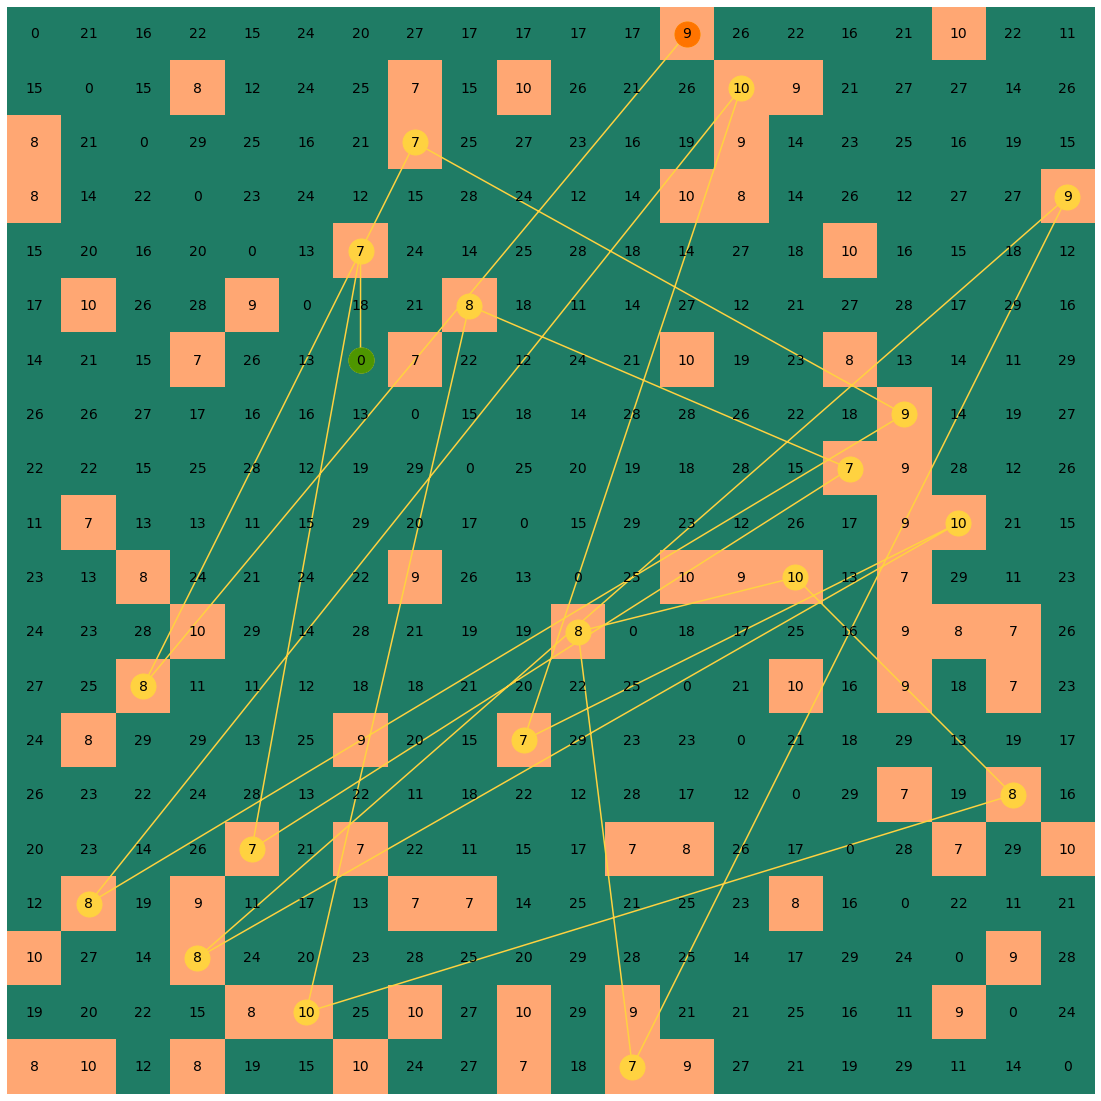

time: 157


In [449]:
hung = Hungarian(random_generate=True, checkpoints_cnt=20, minmax=(7, 30))
paths = hung.process()
print(paths[0])
hung.show_result([paths[0]])
print(f'time: {hung.get_time(paths[0])}')

In [450]:
import importlib as im
import genetics
im.reload(utils)
im.reload(genetics)

from genetics import GeneticRemovingZeros

genetic = GeneticRemovingZeros(checkpoint_count=8)

In [451]:
class GeneticDriver(genetics.GeneticAlgoritm):
    def __init__(self, field : np.array, driver_count:int):
        """Конструктор генетического алгоритма сортировки водителей

        Args:
            field (np.array): временная карта
            driver_count (int): количество водителей
        """
        super().__init__()
        self.field = field
        self.population_size = 100
        self.nsurv = 20
        self.nnew = self.population_size - self.nsurv
        self.epochs = 10
        self.driver_count = driver_count
        self.bot_length = self.field.shape[0]
        self.popul = np.random.choice(self.driver_count, size=(self.population_size, self.bot_length))


    def get_fields(self, bot:np.array) -> list:
        fields = []
        for i in range(self.driver_count):
            fields.append(utils.cut_matrix(self.field, np.where(np.concatenate((bot, bot)) == i, 0, 1)))
        return fields


    def process(self):
        validation = np.zeros(shape=self.population_size).astype(np.int16)
        start_bot = 0
        for e in range(self.epochs):            
            print(f'epoch {e}')
            if e>0:
                start_bot = self.nsurv
                validation[start_bot:]=0
            for i, bot in enumerate(self.popul[start_bot:]):
                fields = self.get_fields(bot)
                current_val = []
                for field in fields:
                    if field.size<=1:
                        continue
                    current_hungarian = Hungarian(data=field)
                    paths = current_hungarian.process()
                    times = []
                    for path in paths:
                        times.append(current_hungarian.get_time(path))
                    current_val.append(min(times))
                validation[i+start_bot]=max(current_val)
            print(validation[validation.argsort()])
            new_popul = self.popul[validation.argsort()]
            validation.sort()
            for i in range(self.nnew):
                new_popul[self.nsurv+i] = self.cross_point(new_popul)
                if np.random.random() < self.mut:
                    new_popul[self.nsurv+i] = np.random.choice(self.driver_count, size=self.bot_length)
            self.popul = new_popul
        return self.popul, validation

In [452]:
geneticDriver = GeneticDriver(
    field=hung.start_field,
    driver_count=5
)

In [453]:
paths = geneticDriver.process()

epoch 0
[39 39 40 40 42 44 44 46 46 46 47 48 49 49 50 50 51 51 51 52 52 52 52 52
 53 54 54 54 55 55 55 56 56 56 57 57 57 57 57 58 58 58 58 58 59 59 59 60
 60 60 60 60 60 61 61 61 61 61 61 62 62 62 62 63 63 63 63 64 64 64 65 65
 65 65 65 65 65 66 66 67 67 67 68 68 68 69 69 70 71 71 72 73 73 73 74 75
 76 84 85 90]
epoch 1
[39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39 39 39 39 39 39 40 40 42 44 44 45 46 46 46 47 48 48 49 49
 50 50 50 50 50 51 51 51 51 51 52 54 55 57 57 57 57 58 62 64 65 66 66 67
 71 73 79 89]
epoch 2
[39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39 41 43 46 49 52 53 54 54 55 56 58 59 60 61 61 62 62 64 65
 72 76 80 84]
epoch 3
[39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 3

In [454]:
fields = geneticDriver.get_fields(paths[0][0])
path_result = []
for field in fields:
    cur_best_path = []
    if field.size<=1:
        continue
    current_hungarian = Hungarian(data=field)
    current_paths = current_hungarian.process()
    min_time = 201
    for path in current_paths:
        t = current_hungarian.get_time(path)
        if t < min_time:
            min_time = t
            cur_best_path = path
    path_result.append(cur_best_path)

In [455]:
path_result

[array([2, 3, 0, 1], dtype=int64),
 array([1, 0, 2, 4, 3], dtype=int64),
 array([3, 1, 2, 0], dtype=int64),
 array([3, 2, 1, 0], dtype=int64),
 array([2, 0, 1], dtype=int64)]

In [456]:
results = [utils.rearrange_positions(paths[0][0], path_result[i], i) for i in range(len(path_result))]

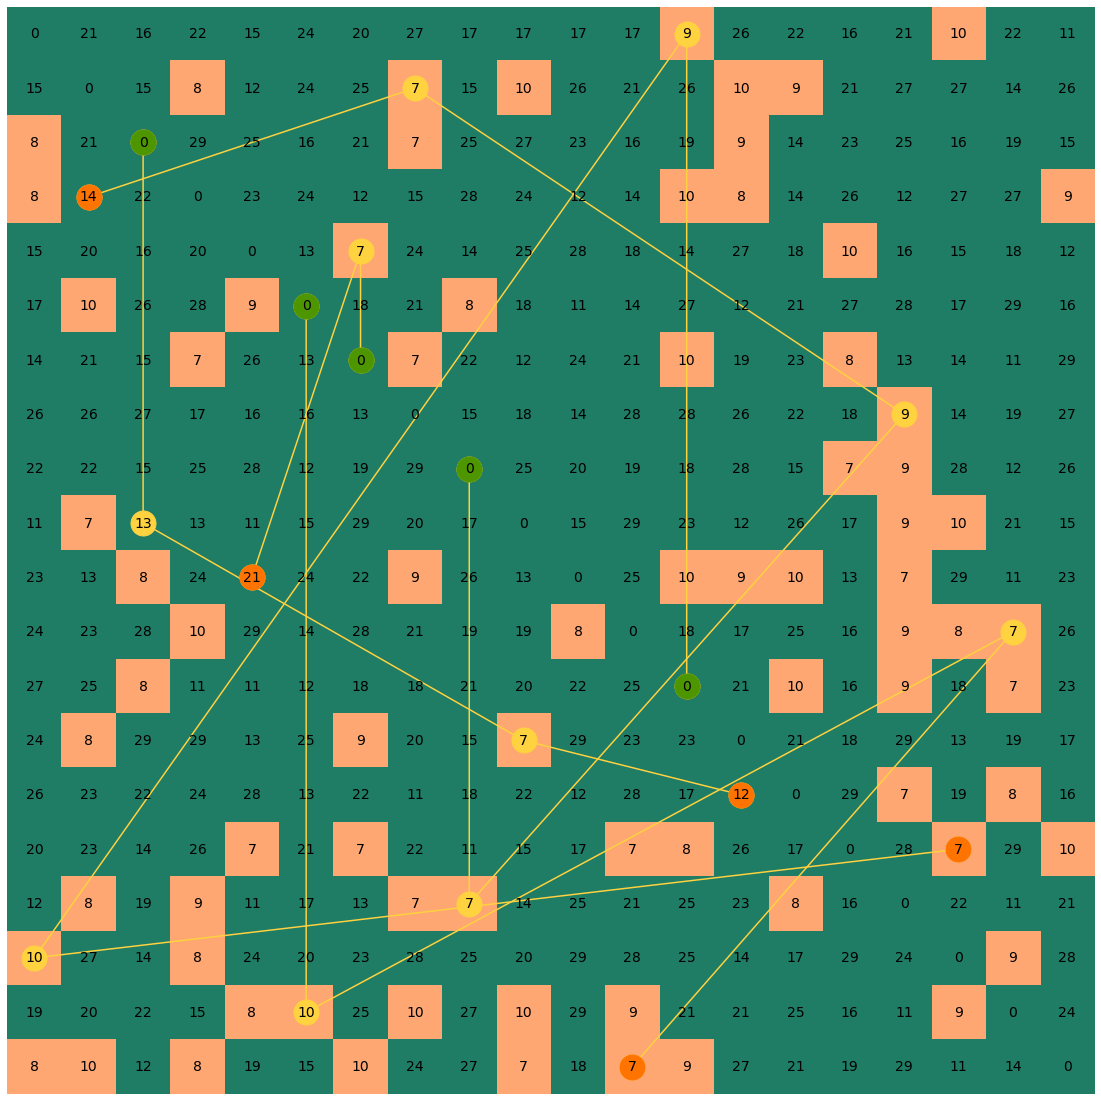

time:
d1 - 26
d2 - 37
d3 - 24
d4 - 32
d5 - 28


In [457]:
hung.show_result(results)
print(f'time:')
for i, re in enumerate(results):
    print(f'd{i+1} - {hung.get_time(re)}')